<a href="https://colab.research.google.com/github/tomasz-te/Assets-prices-prediction/blob/main/Assets_prices_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1. Problem statement
---
The goal of this project is to check whether basic machine learning models can be helpful in predicting future prices of assets such as stocks, commodities and cryptocurrencies. We will choose very different assets for analysis, namely: INTEL (big value), VBK (ETF, small growth), China Yuchai International (micro value), coffee, silver, Bitcoin and Litecoin.

### 2. Data collection
---
We will use daily closing prices of the assets for the past five years for the analysis. Additionally, we will need some other economic data that may have an impact on the asset price. Let's choose the 5 Year Treasury yield, Federal Funds Effective Rate and the Euros to US Dollars exchange rate.

In [61]:
#!pip install yfinance
import pandas_datareader.data as web
import yfinance as yf
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [3]:
fed = web.DataReader('FEDFUNDS', 'fred')

In [4]:
yahoo_tickers = ['INTC','VBK','CYD','KC=F','SI=F','BTC-USD','LTC-USD','^FVX','EURUSD=X']
now = dt.datetime.now()
starting_date = str(int(now.strftime("%Y"))-5)+"-"+now.strftime("%m")+"-"+now.strftime("%d")
data = yf.download(yahoo_tickers,start=starting_date)

[*********************100%***********************]  9 of 9 completed


In [5]:
data = data['Close']
data.head()

,BTC-USD,CYD,EURUSD=X,INTC,KC=F,LTC-USD,SI=F,VBK,^FVX
Date,,,,,,,,,
2017-04-06,1182.680054,18.650000,1.067247,36.029999,137.750000,10.25170,18.225000,139.380005,1.863
2017-04-07,1176.900024,18.600000,1.064464,36.029999,140.050003,9.37156,18.129999,139.250000,1.911
2017-04-08,1175.949951,NaN,NaN,NaN,NaN,9.91621,NaN,NaN,NaN
2017-04-09,1187.869995,NaN,NaN,NaN,NaN,8.70985,NaN,NaN,NaN
2017-04-10,1187.130005,18.469999,1.058201,35.799999,139.850006,8.91704,17.893999,139.509995,1.900


In [6]:
data = pd.concat([data, fed],axis=1)
data.head(2)

,BTC-USD,CYD,EURUSD=X,INTC,KC=F,LTC-USD,SI=F,VBK,^FVX,FEDFUNDS
2017-04-06,1182.680054,18.65,1.067247,36.029999,137.750000,10.25170,18.225000,139.380005,1.863,NaN
2017-04-07,1176.900024,18.60,1.064464,36.029999,140.050003,9.37156,18.129999,139.250000,1.911,NaN


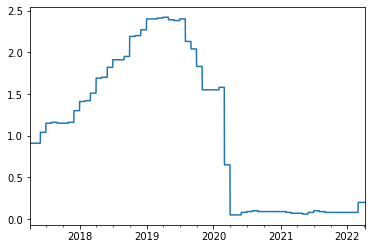

In [7]:
data['FEDFUNDS'].fillna(method='ffill', inplace=True)
data['FEDFUNDS'].fillna(method='bfill', inplace=True)
data['FEDFUNDS'].plot()

In [8]:
data.head()

,BTC-USD,CYD,EURUSD=X,INTC,KC=F,LTC-USD,SI=F,VBK,^FVX,FEDFUNDS
2017-04-06,1182.680054,18.650000,1.067247,36.029999,137.750000,10.25170,18.225000,139.380005,1.863,0.91
2017-04-07,1176.900024,18.600000,1.064464,36.029999,140.050003,9.37156,18.129999,139.250000,1.911,0.91
2017-04-08,1175.949951,NaN,NaN,NaN,NaN,9.91621,NaN,NaN,NaN,0.91
2017-04-09,1187.869995,NaN,NaN,NaN,NaN,8.70985,NaN,NaN,NaN,0.91
2017-04-10,1187.130005,18.469999,1.058201,35.799999,139.850006,8.91704,17.893999,139.509995,1.900,0.91


### 3. Data cleaning
We will remove the rows for Saturdays and Sundays as only cryptocurrencies are traded on the weekend. Next we will check to see if there are any other missing values.

In [9]:
data = data[data.index.dayofweek < 5]

In [10]:
data.isna().sum()

BTC-USD      1
CYD         46
EURUSD=X     3
INTC        46
KC=F        45
LTC-USD      1
SI=F        47
VBK         46
^FVX        46
FEDFUNDS     0
dtype: int64

The remaining missing values are related to public holidays. As we only have quotes for currencies and cryptocurrencies these days, let's remove them.

In [11]:
data.dropna(inplace=True)
print(data.isna().sum().sum())
print(data.shape)

0
(1256, 10)


/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [12]:
data = data.rename(columns={'BTC-USD':'BTC','EURUSD=X':'EUR','KC=F':'COF','LTC-USD':'LTC','SI=F':'SIL','^FVX':'5YT','FEDFUNDS':'FED'})

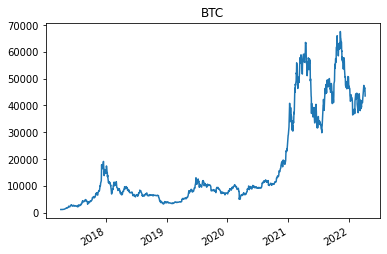

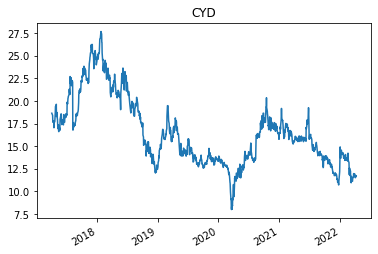

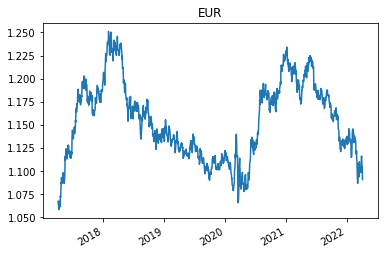

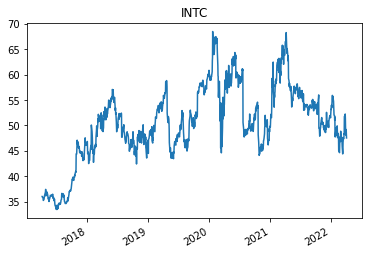

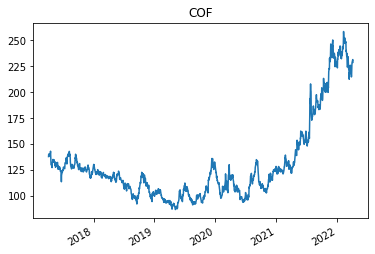

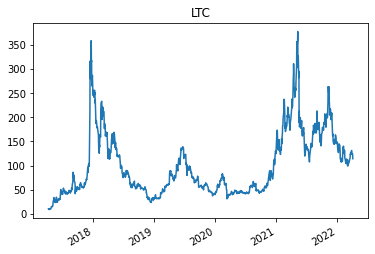

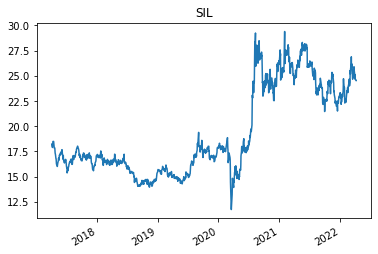

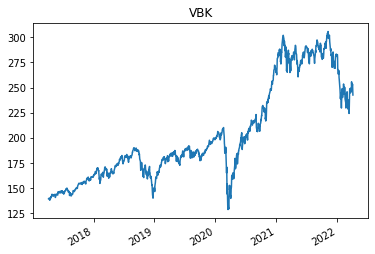

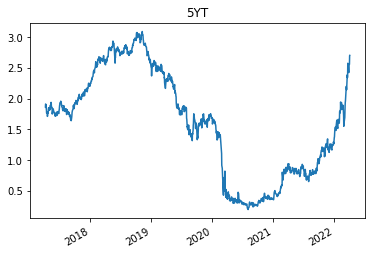

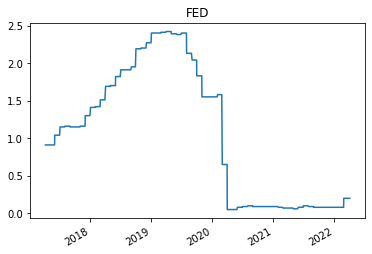

In [13]:
for column in data:
  data[column].plot().set_title(column)
  plt.show()

In [14]:
data.columns

Index(['BTC', 'CYD', 'EUR', 'INTC', 'COF', 'LTC', 'SIL', 'VBK', '5YT', 'FED'], dtype='object')

In [15]:
# Preparing targets for assets. Will price go up in next 5 days?
assets_to_predict = ['BTC', 'CYD', 'INTC', 'COF', 'LTC', 'SIL', 'VBK']
for asset in assets_to_predict:
    data[asset + "_target"] = data.rolling(6).apply(lambda x: x.iloc[5] > x.iloc[0])[asset]

In [16]:
data.iloc[:8]

,BTC,CYD,EUR,INTC,COF,LTC,SIL,VBK,5YT,FED,BTC_target,CYD_target,INTC_target,COF_target,LTC_target,SIL_target,VBK_target
2017-04-06,1182.680054,18.650000,1.067247,36.029999,137.750000,10.25170,18.225000,139.380005,1.863,0.91,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-04-07,1176.900024,18.600000,1.064464,36.029999,140.050003,9.37156,18.129999,139.250000,1.911,0.91,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-04-10,1187.130005,18.469999,1.058201,35.799999,139.850006,8.91704,17.893999,139.509995,1.900,0.91,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-04-11,1205.010010,18.410000,1.059760,35.740002,140.199997,8.85383,18.233000,140.289993,1.832,0.91,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-04-12,1200.369995,17.730000,1.061132,35.630001,138.300003,10.78560,18.278999,139.059998,1.830,0.91,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-04-13,1169.280029,17.639999,1.067065,35.250000,138.899994,10.14950,18.489000,137.949997,1.764,0.91,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2017-04-17,1193.910034,17.809999,1.061053,35.480000,141.100006,10.42160,18.493000,139.539993,1.777,0.91,1.0,0.0,0.0,1.0,1.0,1.0,1.0
2017-04-18,1211.670044,17.620001,1.064453,35.770000,142.899994,10.32010,18.250999,139.520004,1.710,0.91,1.0,0.0,0.0,1.0,1.0,1.0,1.0


In [17]:
# Now we need to shift our targets backward (or features forward), because we want to predict the future outcome, not knowing current result.
for column in data:
  if "target" not in column:
    data[column]=data[column].shift(5)

In [18]:
data.head(7)

,BTC,CYD,EUR,INTC,COF,LTC,SIL,VBK,5YT,FED,BTC_target,CYD_target,INTC_target,COF_target,LTC_target,SIL_target,VBK_target
2017-04-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-04-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-04-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-04-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-04-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-04-13,1182.680054,18.65,1.067247,36.029999,137.750000,10.25170,18.225000,139.380005,1.863,0.91,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2017-04-17,1176.900024,18.60,1.064464,36.029999,140.050003,9.37156,18.129999,139.250000,1.911,0.91,1.0,0.0,0.0,1.0,1.0,1.0,1.0


In [19]:
data = data.iloc[5:]
data.head(2)

,BTC,CYD,EUR,INTC,COF,LTC,SIL,VBK,5YT,FED,BTC_target,CYD_target,INTC_target,COF_target,LTC_target,SIL_target,VBK_target
2017-04-13,1182.680054,18.65,1.067247,36.029999,137.750000,10.25170,18.225000,139.380005,1.863,0.91,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2017-04-17,1176.900024,18.60,1.064464,36.029999,140.050003,9.37156,18.129999,139.250000,1.911,0.91,1.0,0.0,0.0,1.0,1.0,1.0,1.0


In [23]:
data.to_csv('Assets_prices_prediction.csv')

In [24]:
data.tail()

,BTC,CYD,EUR,INTC,COF,LTC,SIL,VBK,5YT,FED,BTC_target,CYD_target,INTC_target,COF_target,LTC_target,SIL_target,VBK_target
2022-03-31,43960.933594,11.85,1.100631,51.619999,221.850006,126.581276,25.900000,247.940002,2.373,0.2,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2022-04-01,44348.730469,11.96,1.100958,51.830002,221.850006,124.067368,25.594999,246.470001,2.573,0.2,1.0,0.0,0.0,1.0,1.0,0.0,1.0
2022-04-04,47128.003906,11.92,1.098189,51.509998,214.550003,127.938614,25.176001,247.360001,2.565,0.2,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2022-04-05,47465.730469,11.91,1.099384,52.250000,215.699997,130.061234,24.716000,255.740005,2.485,0.2,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2022-04-06,47062.664062,11.83,1.109152,51.430000,221.850006,131.169342,25.103001,251.199997,2.448,0.2,0.0,0.0,0.0,1.0,0.0,0.0,0.0


###MODELS

In [48]:
train = data.iloc[:int(data.shape[0]*0.8)]
test = data.iloc[int(data.shape[0]*0.8):]
predictors = [column for column in data if 'target' not in column]
targets = [column for column in data if 'target' in column]
print(predictors, targets)

['BTC', 'CYD', 'EUR', 'INTC', 'COF', 'LTC', 'SIL', 'VBK', '5YT', 'FED'] ['BTC_target', 'CYD_target', 'INTC_target', 'COF_target', 'LTC_target', 'SIL_target', 'VBK_target']


In [63]:
models = []
models.append(("LR", LogisticRegression()))
models.append(('TREE', DecisionTreeClassifier()))
models.append(("RF", RandomForestClassifier()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('AB', AdaBoostClassifier()))
models.append(('GRAD', GradientBoostingClassifier()))



In [87]:
results = []
for target in targets:
  for name, model in models:
    model.fit(train[predictors], train[target])
    predictions = model.predict(test[predictors])
    accuracy = accuracy_score(test[target], predictions)
    results.append((target.strip("_target"), name, accuracy))
print(results)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[('BTC', 'LR', 0.5976095617529881), ('BTC', 'TREE', 0.4581673306772908), ('BTC', 'RF', 0.46613545816733065), ('BTC', 'KNN', 0.46613545816733065), ('BTC', 'AB', 0.47808764940239046), ('BTC', 'GRAD', 0.5577689243027888), ('CYD', 'LR', 0.4262948207171315), ('CYD', 'TREE', 0.4103585657370518), ('CYD', 'RF', 0.350597609561753), ('CYD', 'KNN', 0.47410358565737054), ('CYD', 'AB', 0.50199203187251), ('CYD', 'GRAD', 0.3944223107569721), ('INTC', 'LR', 0.44223107569721115), ('INTC', 'TREE', 0.41434262948207173), ('INTC', 'RF', 0.5099601593625498), ('INTC', 'KNN', 0.4063745019920319), ('INTC', 'AB', 0.5617529880478087), ('INTC', 'GRAD', 0.50199203187251), ('COF', 'LR', 0.4541832669322709), ('COF', 'TREE', 0.4342629482071713), ('COF', 'RF', 0.41434262948207173), ('COF', 'KNN', 0.549800796812749), ('COF', 'AB', 0.4820717131474104), ('COF', 'GRAD', 0.47808764940239046), ('LTC', 'LR', 0.649402390438247), ('LTC', 'TREE', 0.49800796812749004), ('LTC', 'RF', 0.5139442231075697), ('LTC', 'KNN', 0.4741035

In [88]:
results_df = pd.DataFrame(results, columns=['Target','Model','Accuracy'])
results_df.head()


,Target,Model,Accuracy
0,BTC,LR,0.597610
1,BTC,TREE,0.458167
2,BTC,RF,0.466135
3,BTC,KNN,0.466135
4,BTC,AB,0.478088


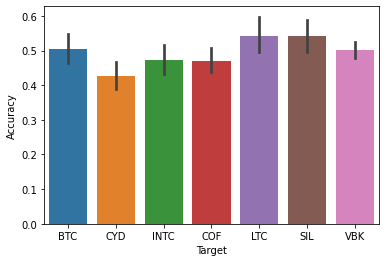

In [92]:
sns.barplot(x=results_df['Target'], y=results_df['Accuracy'])

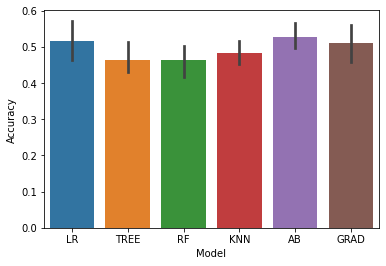

In [93]:
sns.barplot(x=results_df['Model'], y=results_df['Accuracy'])

In [96]:
results_df.sort_values('Accuracy', ascending=False).head(10)

,Target,Model,Accuracy
24,LTC,LR,0.649402
35,SIL,GRAD,0.621514
28,LTC,AB,0.609562
0,BTC,LR,0.597610
31,SIL,TREE,0.581673
34,SIL,AB,0.573705
16,INTC,AB,0.561753
5,BTC,GRAD,0.557769
21,COF,KNN,0.549801
39,VBK,KNN,0.541833


### Conclusions

Silver and Crypto, Logistic, Ada, Grads
